#  Monte Carlo Control for Q Table and Optimal Policy


In [50]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Blackjack environment: [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py)

In [2]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(13, 1, True)
End game! Reward:  1.0
You won :)

(14, 2, False)
End game! Reward:  -1
You lost :(

(19, 1, False)
End game! Reward:  -1
You lost :(



### Monte Carlo Prediction

Begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
def generate_episode_from_limit_stochastic(env):
    
    episode = []
    
    # 0 -> player sum, 1- dealers face up card, 2- usable ace or not
    state = env.reset()
    
    while True: 
        probability = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        
        action = np.random.choice(np.arange(2), p = probability)
        
        next_state, reward, done, info = env.step(action)
        
        episode.append((state, action, reward))
        
        state = next_state
        
        if done: 
            break
        
    return episode

In [6]:
for i in range(1):
    episode = generate_episode_from_limit_stochastic(env)
    
    state, action, reward = zip(*episode)
    
    print(episode)
    print(state)
    print(action)
    print(reward)
    

[((11, 4, False), 1, 0), ((12, 4, False), 1, 0), ((16, 4, False), 0, -1.0)]
((11, 4, False), (12, 4, False), (16, 4, False))
(1, 1, 0)
(0, 0, -1.0)


In [8]:
reward = [1, 1]
gamma = 0.5

discount = np.array([gamma ** i for i in range(len(reward) + 1)])

i = 0
discounted1 = sum(reward[i : ] * discount[ : -(i + 1)])

i = 1
discounted2 = sum(reward[i : ] * discount[ : -(i + 1)])

print(discount)
print(discounted1)
print(discounted2)


[1.   0.5  0.25]
1.5
1.0


### First Visit Monte Carlo Prediction 

Algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [9]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate episdoe
        episodes = generate_episode(env)
        
        states, actions, rewards = zip(*episodes)
        discounts = np.array([gamma ** i for i in range(len(states))])
                
        state_actions = list()
        
        for i, state in enumerate(states): 
            
            action = actions[i]
                        
            # First Visit Monte Carlo Prediction
            if [state, action] not in state_actions:
                
                state_actions.append([state, action])
                # calculate discounted reward from this state to last
                action_reward = sum(rewards[i:] * discounts[:(len(discounts) - i)])
                
                N[state][action] += 1
                returns_sum[state][action] += action_reward
    
    for state in N:
        N[state][N[state] == 0] = 1
        
        # calcualte average across all state visits
        Q[state] = returns_sum[state] / N[state]
    
    return Q

In [10]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

In [11]:
Q

defaultdict(<function __main__.mc_prediction_q.<locals>.<lambda>()>,
            {(4, 1, False): array([-0.85714286, -0.59793814]),
             (4, 2, False): array([-0.44      , -0.38586957]),
             (4, 3, False): array([-0.3559322 , -0.32142857]),
             (4, 4, False): array([-0.26829268, -0.29378531]),
             (4, 5, False): array([-0.20833333, -0.35672515]),
             (4, 6, False): array([-0.08      , -0.24137931]),
             (4, 7, False): array([-0.40425532, -0.17610063]),
             (4, 8, False): array([-0.57142857, -0.40384615]),
             (4, 9, False): array([-0.33333333, -0.45882353]),
             (4, 10, False): array([-0.67346939, -0.50469799]),
             (5, 1, False): array([-0.65116279, -0.61344538]),
             (5, 2, False): array([-0.11904762, -0.41141141]),
             (5, 3, False): array([-0.26315789, -0.44772118]),
             (5, 4, False): array([-0.25      , -0.33423913]),
             (5, 5, False): array([-0.28440367, 

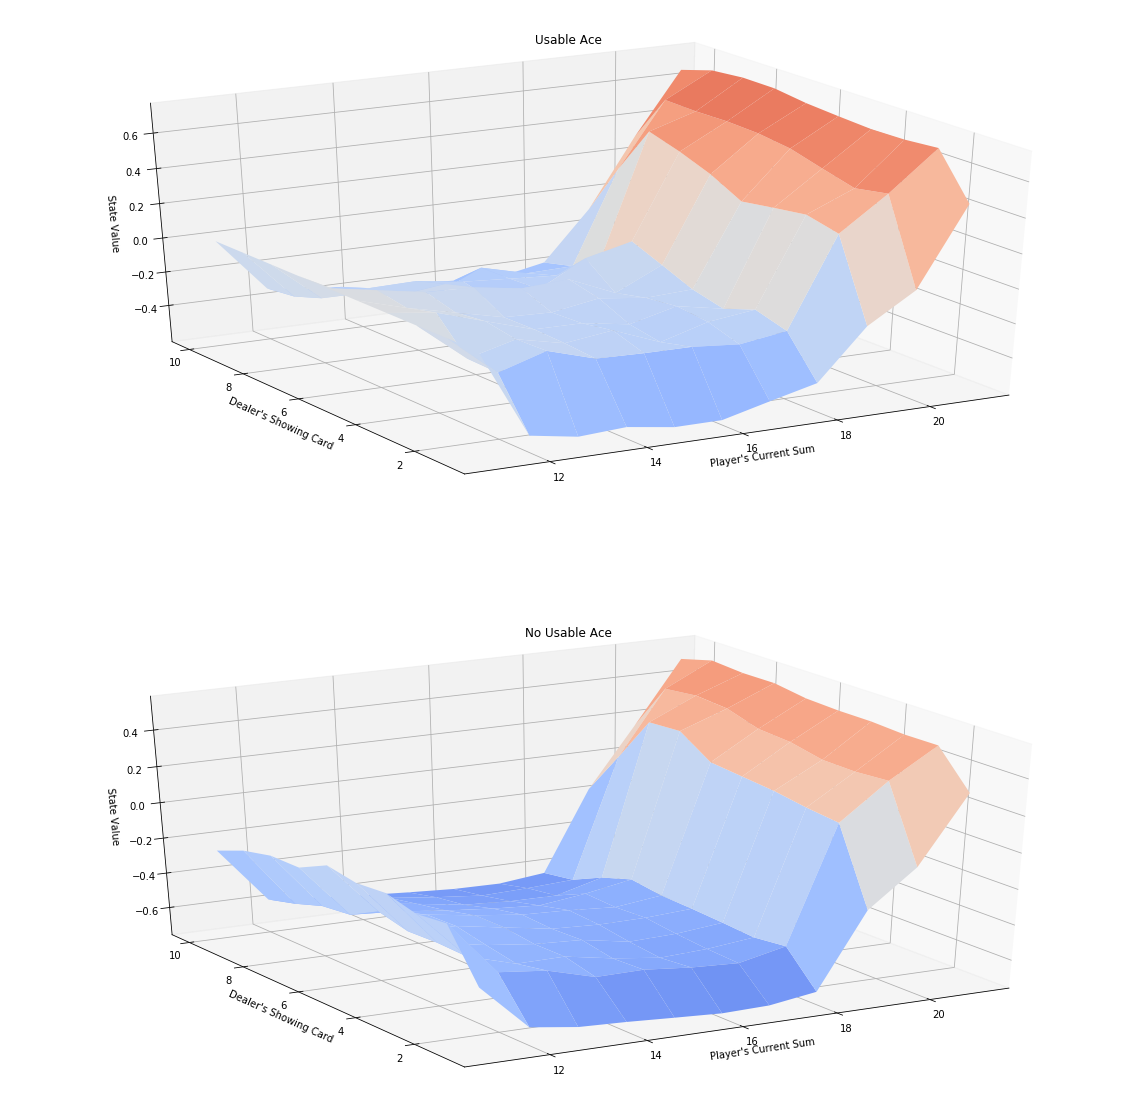

In [12]:
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Constant-$\alpha$ Monte Carlo Control


Four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [48]:
def generate_episode(env, Q, epsilon):
    '''
    Generate episodes under given Q table
    '''
    episode = []
    
    # 0 -> player sum, 1- dealers face up card, 2- usable ace or not
    state = env.reset()
            
    while True:
        
        action = get_state_action(state, Q, epsilon, env.action_space.n)
                        
        next_state, reward, done, info = env.step(action)
        
        episode.append((state, action, reward))
        
        # update current state
        state = next_state
        
        if done:
            break
        
    return episode


def get_state_action(state, Q, epsilon, num_actions):
    '''
    Get the optimal action for given state using epsilon greedy policy
    '''
    
    # assign equal probabilities to each action
    probs = np.ones(num_actions) / num_actions
            
    if state in Q:
        
        # assign equal probabilities to each one
        probs *= epsilon
        
        # find the action with max state-action value
        optim_action = np.argmax(Q[state])
        
        # adjust the probabilities of optimal action
        probs[optim_action] = (1. - epsilon) + (epsilon / num_actions)
       
    return np.random.choice(np.arange(num_actions), p = probs)


def update_q_table(episode, Q, N, returns_sum, alpha, gamma=1.0):
    '''
    Update Q table for given episode
    '''
    
    # get states, actions and corresponding rewards for generated episode
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma ** i for i in range(len(states))])
    
    state_actions = list()
                
    for i, state in enumerate(states):
        
        action = actions[i]
        
        # First visit Monte Carlo
        if [state, action] not in state_actions:
            
            state_actions.append([state, action])
            
            # calculate discounted total reward from this state to terminal state
            reward = sum(rewards[i:] * discounts[:(len(discounts) - i)])
                                    
            N[state][action] += 1
            returns_sum[state][action] += reward
            
            state_action_value = returns_sum[state][action] / N[state][action]
        
            # update Q table
            Q[state][action] += alpha * (state_action_value - Q[state][action])
                       
                                                    
    return Q, N, returns_sum


def get_policy(Q):
    '''
    Get the policy from Q table
    '''
    
    policy = dict()
    
    for state in Q:
        policy[state] = np.argmax(Q[state])
        
    return policy
        
    
def monte_carlo_control(env, num_episodes, alpha, gamma = 1.0,
                        epsilon = 1., epsilon_decay = 0.99999, epsilon_min = 0.05):
    '''
    Monte carlo control method to generate the optimal policy and Q table
    '''
    num_actions = env.action_space.n
    
    # set default Q table for state, action pair to 0
    Q = defaultdict(lambda: np.zeros(num_actions))
    N = defaultdict(lambda: np.zeros(num_actions))
    returns_sum = defaultdict(lambda: np.zeros(num_actions))
        
    for i_episode in range(1, num_episodes+1):
        
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        
        # generate episode
        episode = generate_episode(env, Q, epsilon)
        
        # update Q table
        Q, N, returns_sum = update_q_table(episode, Q, N, returns_sum, alpha, gamma)
           
                    
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
                
    policy = get_policy(Q)
    
    return policy, Q

In [41]:
# obtain the estimated optimal policy and action-value function
policy, Q = monte_carlo_control(env, num_episodes = 500000, alpha = 0.02, gamma = 1.0)

Episode 500000/500000.

Plot the corresponding state-value function.

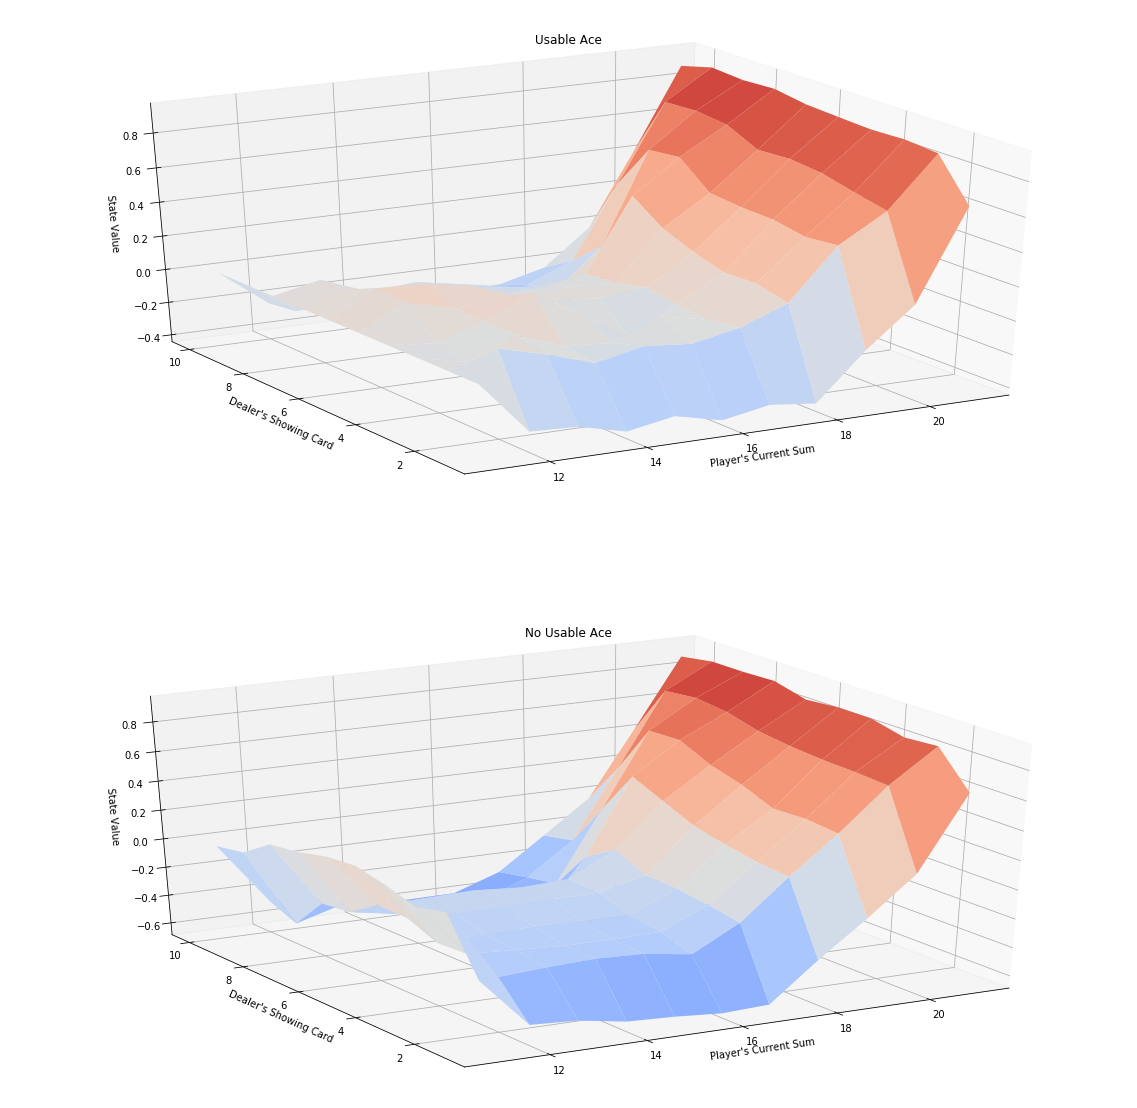

In [46]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Visualize the policy that is estimated to be optimal.

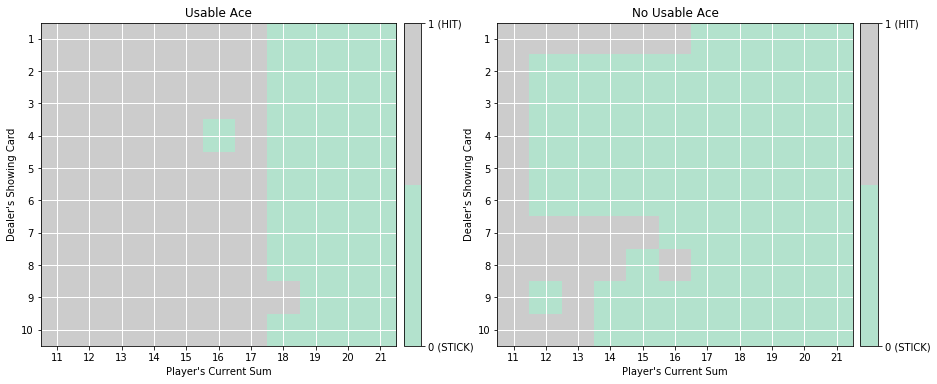

In [49]:
# plot the policy
plot_policy(policy)


The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)